# Part 2: Handling the Cold Start Problem with Content-Based Filtering

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no interactions get excluded from the recommendation system. This is called the "cold start" problem. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

In this tutorial, we will generate item-item recommendations using content-based filtering.

## Exercise 1: Load the Data

Let's assume we're building a recommender system for a new movie platform and we know very little about our current users. We don't have enough interactios data in our system to rely on collaborative filtering. 

What we do have is movie features: which genres a movie belongs to, and which year it was released. 

### <span style="color:green">1. Let's load in our data (`movies.csv`) using pandas and take a look at the first few rows of each dataframe.</span>

In [ ]:
import pandas as pd

movies = pd.read_csv("data/ml-latest-small/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Exercise 2: Data Cleaning and Exploration

Before exploring our movie features dataset, we need to clean in two ways:

1. Genres is expressed as a string with a pipe | separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
2. Title currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

### <span style="color:green"> 2.1 Converting Genres from String Format to List </span>

The genres column is currently a string separated with pipes. Let's convert this into a list using the "split" function.

We want 
`"Adventure|Children|Fantasy"`
to convert to this:
`[Adventure, Children, Fantasy]`.

In [2]:
# genres = [genre.split('|') for genre in movies['genres']]
# movies['genres'] = genres

movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
movies

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"


#### <span style="color:green">2.2 How many movie genres are there?</span>

We can use Python's Counter to create a dictionary containing frequency counts of each genre in our dataset.

In [3]:
from collections import Counter

counter = Counter(g for genre in movies['genres'] for g in genre)
print(f"Genres: {len(counter)}")
counter

Genres: 20


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

### <span style="color:green">2.3 Removing Movies with No Genres</span>

There are 20 genre labels and 19 genres that are used to describe movies in this dataset. Some movies don't have any genres, hence the label `(no genres listed)`. 

Let's remove all movies having `(no genres listed)` as its genre label. We'll also remove this from our `genre_counts` dictionary. 

In [4]:
no_genre_movies = []

for i, genres in enumerate(movies['genres']):
    if len(genres) == 1:
        if genres[0] == '(no genres listed)':
            no_genre_movies.append(i)

movies = movies.drop(no_genre_movies)
movies.shape

(9708, 3)

In [5]:
counter = Counter(g for genre in movies['genres'] for g in genre)
print(f"Genres: {len(counter)}")
counter

Genres: 19


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87})

### <span style="color:green">2.4 What are the most popular genres?</span>

We can use `Counter`'s [most_common()](https://docs.python.org/2/library/collections.html#collections.Counter.most_common) method to get the genres with the highest movie counts.

In [6]:
counter.most_common(5)

[('Drama', 4361),
 ('Comedy', 3756),
 ('Thriller', 1894),
 ('Action', 1828),
 ('Romance', 1596)]

The top 5 genres are: `Drama`, `Comedy`, `Thriller`, `Action` and `Romance`. 

### <span style="color:green">2.5 Visualizing Genres Popularity</span>

Let's also visualize genres popularity with a barplot.

C:\Users\diogo\AppData\Local\Temp\ipykernel_444\1255144040.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Genre', data=genres_counts_df, palette='viridis')


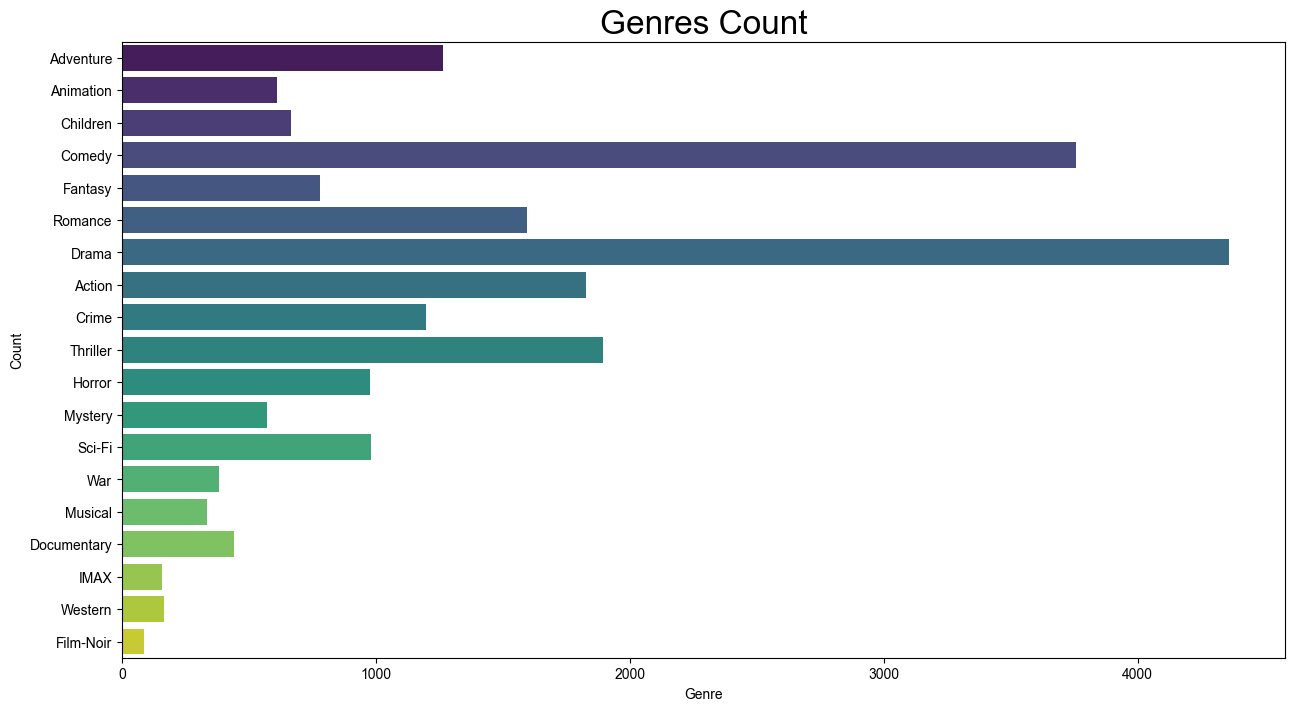

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

genres_counts_df = pd.DataFrame([counter]).T.reset_index()
genres_counts_df.columns = ['Genre', 'Count']

plt.figure(figsize=(15,8))
sns.barplot(x='Count', y='Genre', data=genres_counts_df, palette='viridis')
sns.set_theme("poster")
plt.title("Genres Count")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

The plot above shows that `Drama` and `Comedy` are the two most popular movie genres. The least popular movie genres are `Westerns`, `IMAX`, and `Film-Noir`.

### <span style="color:green">2.6 Extracting Year from Title</span>

In our dataset, movie titles currently the year of release appended to it in brackets, e.g., `"Toy Story (1995)"`. We want to use the year of a movie's release as a feature, so let's parse it out from the title string and create a new `year` column for it.

We can start with writing a function that parses out year from the title string. In the code below, `extract_year_from_title()` takes in the title and does the following:

- generates a list by splitting out each word by spaces (e.g., `["Toy", "Story", "(1995)"]`)
- gets the last element of the list (e.g., `"(1995)"`)
- if the last element has brackets surrounding it, these `()` brackets get stripped (e.g., `"1995"`)
- converts the year into an integer 

In [8]:
import re 

def extract_year_from_title(title):
    t = title.split()
    year = None
    if re.search(r"\d{4}", t[-1]):
        year = int(t[-1].strip("()"))
    return year

We can test out this function with our example of `"Toy Story (1995)"`:

In [9]:
title = "Toy Story (1995)"
year = extract_year_from_title(title)
print(f"Year of release: {year}")
print(type(year))

Year of release: 1995
<class 'int'>


Our function `extract_year_from_title()` works! It's able to successfully parse out year from the title string as shown above. We can now apply this to all titles in our `movies` dataframe using Pandas' [apply()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) method.

In [10]:
movies['year'] = movies['title'].apply(extract_year_from_title)

### <span style="color:green">2.7 How many years of movie releases are in our dataset?</span>

In [11]:
# len(movies['year'].value_counts())
movies['year'].nunique()

106

There are over 100 years of release in our dataset. Let's collapse this down into decades to get a general sense of when movies were released in our dataset. 

### <span style="color:green">2.8 What was the most popular decade of movie release?</span>

Before we begin, we'll remove all movies with null year.

In [12]:
print(f"Original number of movies: {movies['movieId'].nunique()}")

Original number of movies: 9708


In [13]:
movies = movies[~movies['year'].isna()]
movies['movieId'].nunique()

9704

In [14]:
movies

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995.0
4,5,Father of the Bride Part II (1995),[Comedy],1995.0
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",2017.0
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",2017.0
9739,193585,Flint (2017),[Drama],2017.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",2018.0


We filtered out 24 movies that don't have a year of release. 

Now, there are two ways to get the decade of a year:

1. converting year to string, replacing the fourth (last) number with a 0
2. rounding year down to the nearest 10 

We'll show both implementations in the code below:

In [15]:
x = 1995

def get_decade(year):
    decade = str(year)[:3]
    decade = f"{decade}0"
    return int(decade)

get_decade(x)

1990

In [16]:
def round_down(year):
    return year - year % 10

round_down(x)

1990

The two functions `get_decade()` and `round_down()` both accomplish the same thing: they both get the decade of a year.

We can apply either of these functions to all years in our `movies` dataset. We'll use `round_down()` in this example to a create a new column called `'decade'`:

In [17]:
movies['decade'] = movies['year'].apply(round_down)

C:\Users\diogo\AppData\Local\Temp\ipykernel_444\1571598196.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=decades.index, y=decades.values, palette='viridis')


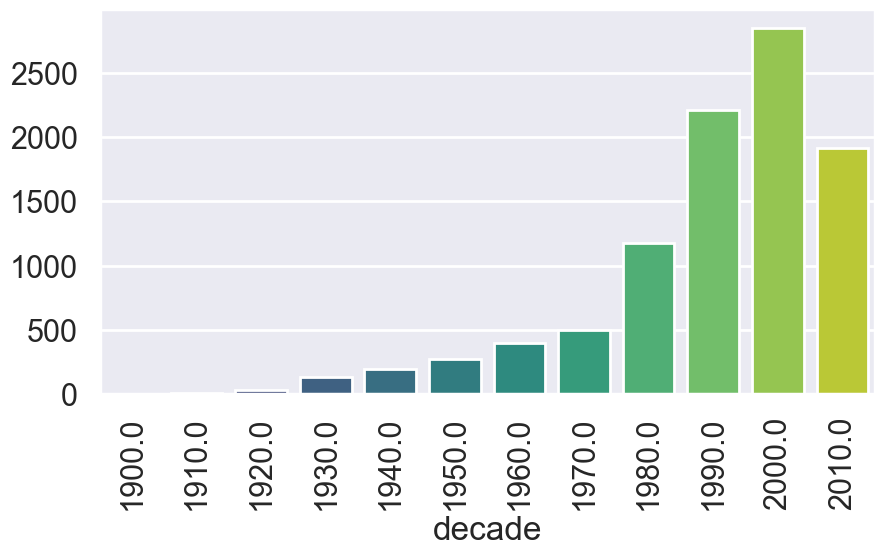

In [18]:
decades = movies['decade'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.barplot(x=decades.index, y=decades.values, palette='viridis')
plt.xticks(rotation=90)
plt.show()

As we can see from the plot above, the most common decade is the 2000s followed by the 1990s for movies in our dataset.

## Exercise 3: Transforming the Data

In order to build a content-based filtering recommender, we need to set up our dataset so that rows represent movies and columns represent features (i.e., genres and decades).

### <span style="color:green">3.1 One-Hot Encoding Genres</span>

First, we need to manipulate the `genres` column so that each genre is represented as a separate binary feature. "1" indicates that the movie falls under a given genre, while "0" does not. 

In [19]:
genres = list(counter.keys())

for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))

Let's take a look at what the movie genres columns look like:

In [20]:
movies[genres].head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### <span style="color:green">3.2 One-Hot Encoding Decades</span>

Great! Our genres columns are represented as binary feautres. The next step is to wrangle our `decade` column so that each decade has its own column. We can do this using pandas' [get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) function, which works by creating a categorical variable into binary variables.

In [21]:
movies_decades = pd.get_dummies(movies['decade'])
movies_decades

,1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,False,False,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9737,False,False,False,False,False,False,False,False,False,False,False,True
9738,False,False,False,False,False,False,False,False,False,False,False,True
9739,False,False,False,False,False,False,False,False,False,False,False,True
9740,False,False,False,False,False,False,False,False,False,False,False,True


### <span style="color:green">3.3 Combining Genres and Decades</span>

Now, let's create a new `movie_features` dataframe by combining our genres features and decade features. We can do this using pandas' [concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) function which concatenates (appends) genres and decades into a single dataframe.

In [22]:
movie_features = pd.concat([movies[genres], movies_decades], axis=1)
movie_features

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,...,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,1,1,1,1,1,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
1,1,0,1,0,1,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
2,0,0,0,1,0,1,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
3,0,0,0,1,0,1,1,0,0,0,...,False,False,False,False,False,False,False,True,False,False
4,0,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,1,0,0,1,0,0,...,False,False,False,False,False,False,False,False,False,True
9738,0,1,0,1,1,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
9739,0,0,0,0,0,0,1,0,0,0,...,False,False,False,False,False,False,False,False,False,True
9740,0,1,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,False,False,True


Our `movie_features` dataframe is ready. The next step is to start building our recommender. 

## Exercise 4: Building a "Similar Movies" Recommender Using Cosine Similarity

We're going to build our item-item recommender using a similarity metric called [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). 

Cosine similarity looks at the cosine angle between two vectors (e.g., $A$ and $B$). The smaller the cosine angle, the higher the degree of similarity between $A$ and $B$. You can calculate the similarity between $A$ and $B$ with this equation:

$$\cos(\theta) = \frac{A\cdot B}{||A|| ||B||}$$

In this tutorial, we're going to use scikit-learn's cosine similarity [function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to generate a cosine similarity matrix of shape $(n_{\text{movies}}, n_{\text{movies}})$. With this cosine similarity matrix, we'll be able to extract movies that are most similar to the movie of interest.

### <span style="color:green">4.1 Calculating Cosine Similarity</span>

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Dimensions of our movie features cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our movie features cosine similarity matrix: (9704, 9704)


As expected, after passing the `movie_features` dataframe into the `cosine_similarity()` function, we get a cosine similarity matrix of shape $(n_{\text{movies}}, n_{\text{movies}})$.

This matrix is populated with values between 0 and 1 which represent the degree of similarity between movies along the x and y axes.

In [60]:
cosine_sim[:5, :5]

array([[1.        , 0.81649658, 0.47140452, 0.40824829, 0.57735027],
       [0.81649658, 1.        , 0.28867513, 0.25      , 0.35355339],
       [0.47140452, 0.28867513, 1.        , 0.8660254 , 0.81649658],
       [0.40824829, 0.25      , 0.8660254 , 1.        , 0.70710678],
       [0.57735027, 0.35355339, 0.81649658, 0.70710678, 1.        ]])

### <span style="color:green">4.2 Creating a Movie Finder Function With FuzzyWuzzy</span>

Install `fuzzywuzzy` using pip if you haven't already:
```bash
pip install fuzzywuzzy==0.18.0
```

Or via requirements.txt:
```bash
pip install -r requirements.txt
```

Let's say we want to get recommendations for movies that are similar to Jumanji. To get results from our recommender, we need to know the exact title of a movie in our dataset. 

In our dataset, Jumanji is actually listed as `'Jumanji (1995)'`. If we misspell Jumanji or forget to include its year of release, our recommender won't be able to identify which movie we're interested in.  

To make our recommender more user-friendly, we can use a Python package called [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) which will find the most similar title to a string that you pass in. Let's create a function called `movie_finder()` which take advantage of `fuzzywuzzy`'s string matching algorithm to get the most similar title to a user-inputted string. 

In [47]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title, all_titles)

    return closest_match[0]

Let's test this out with our Jumanji example. 

In [55]:
title = movie_finder('toy shory')
title

'Toy Story (1995)'

### <span style="color:green">4.3 Create a `movie_idx` Mapper</span>

To get relevant recommendations for Jumanji, we need to find its index in the cosine simialrity matrix. To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix. 

Let's create a movie index dictionary called `movie_idx` where the keys are movie titles and values are movie indices:

In [56]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
idx

0

### <span style="color:green">4.4 Get Recommendations for Jumanji</span>

Using this handy `movie_idx` dictionary, we know that Jumanji is represented by index 1 in our matrix. Let's get the top 10 most similar movies to Jumanji.

In [57]:
n_recommendations=10

sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:n_recommendations+1]
similar_movies = [sim_score[0] for sim_score in sim_scores]

sim_scores, similar_movies

([(1706, 1.0000000000000002),
  (2355, 1.0000000000000002),
  (559, 0.9258200997725515),
  (1357, 0.9128709291752769),
  (1757, 0.9128709291752769),
  (2539, 0.9128709291752769),
  (5624, 0.9128709291752769),
  (5975, 0.9128709291752769),
  (6114, 0.9128709291752769),
  (7758, 0.9128709291752769)],
 [1706, 2355, 559, 1357, 1757, 2539, 5624, 5975, 6114, 7758])

`similar_movies` is an array of indices that represents Jumanji's top 10 recommendations. We can get the corresponding movie titles by either creating an inverse `movie_idx` mapper or using `iloc` on the title column of the `movies` dataframe.

In [58]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Toy Story (1995):


1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
559                                      Space Jam (1996)
1357                                Borrowers, The (1997)
1757                                 Bug's Life, A (1998)
2539                We're Back! A Dinosaur's Story (1993)
5624    Kirikou and the Sorceress (Kirikou et la sorci...
5975    Asterix & Obelix vs. Caesar (Astérix et Obélix...
6115                            Casper Meets Wendy (1998)
7759    Asterix in America (a.k.a Asterix Conquers Ame...
Name: title, dtype: object

Cool! These recommendations seem pretty relevant and similar to Jumanji. The first 5 movies are family-friendly films from the 90s. 

### <span style="color:green">4.5 Wrap Everything Into a Function</span>

We can test our recommender further with other movie titles. For your convenience, package the steps into a single function which takes in the movie title of interest and number of recommendations. 

In [61]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Recommendations for {title}:")
    print(movies['title'].iloc[similar_movies])

In [64]:
get_content_based_recommendations('shawshank redemption', 5)

Recommendations for Shawshank Redemption, The (1994):
29     Shanghai Triad (Yao a yao yao dao waipo qiao) ...
33                               Dead Man Walking (1995)
86                               Hate (Haine, La) (1995)
102                Young Poisoner's Handbook, The (1995)
211                            Heavenly Creatures (1994)
Name: title, dtype: object
